In [4]:
import json
import os
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime
from pprint import pprint
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer as Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, log_loss, f1_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

warnings.filterwarnings('ignore')

In [5]:
sys.path.append(os.path.join('..', 'src'))

In [6]:
import importlib
import utils, model, params, s04_encoding, s05_2_feature_engineering

importlib.reload(model)
importlib.reload(utils)
from utils import capture_data, build_data_dict
from model import timer, measure_prediction_time, apply_ml_model, save_model_parameters, save_model_metrics
from model import get_folders

importlib.reload(params)
from params import ProjectParameters

importlib.reload(s04_encoding)
importlib.reload(s05_2_feature_engineering)
from s04_encoding import ordinal_encode, one_hot_encode
from s05_2_feature_engineering import build_polynomials, transform_label, treat_skewness

# define functions

In [118]:
def apply_ml_model(alg, data_dict, y_train_set, target_type, 
                   encoding='ordinal', treat_collinearity = False, build_polynomals_method=None, do_transform_label=False, 
                   do_treat_skewness=False,
                   useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    '''
     \n
    target_type might be 'regression' or 'binary'
    '''
    start_time = datetime.now()

    if encoding == 'one-hot':
        set_name = 'X_train_oh'
    elif encoding == 'ordinal':
        set_name = 'X_train'
#     if treat_collinearity == True:
#         set_name = 'X_train_oh_nocol'
    X_train_set = data_dict[set_name]
    if build_polynomals_method: 
        X_train_set = build_polynomials(X_train_set, ProjectParameters().numerical_cols, method = build_polynomals_method)
    if do_transform_label:
#         predictors = X_train_set.columns.to_list()
        y_train_set = transform_label(y_train_set, do_transform_label)
    if do_treat_skewness:
        X_train_set = treat_skewness(X_train_set, set_name)
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(X_train_set[predictors].values, label=y_train_set)
        if target_type == 'regression':
            metrics = ['rmse']
        elif target_type == 'binary':
            metrics = ['logloss']
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics=metrics, early_stopping_rounds=early_stopping_rounds, verbose_eval=True)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(X_train_set[predictors], y_train_set,eval_metric='auc')
    print(type(alg))
        
    #Predict training set:
    X_train_set_predictions = alg.predict(X_train_set[predictors])

#     best_score = cvresult.loc[len(cvresult)-1,['test-rmse-mean']]  
    if target_type == 'regression':
        best_score = mean_squared_error(y_train_set, X_train_set_predictions)
    elif target_type == 'binary':
        best_score = accuracy_score(y_train_set, X_train_set_predictions)
    
    
    #Print model report:
    print ("\nModel Report")
    print ("Score : %.4g" % best_score)
    if target_type == 'regression':
        print ("R2 : %.4g" % r2_score(y_train_set, X_train_set_predictions))
    elif target_type == 'binary':
           print ("f1 : %.4g" % f1_score(y_train_set, X_train_set_predictions))

#     print ("AUC Score (Train): %f" % roc_auc_score(y_train_set, X_train_set_predprob))
    
    train_time = round(timer(start_time),9)
    prediction_time = measure_prediction_time(alg, X_train_set)
    
#     return alg.get_params(), train_time, prediction_time
    return alg, best_score, train_time, prediction_time, X_train_set

# Define paths

In [119]:
inputs = os.path.join('..', 'data', '03_processed')
outputs = os.path.join('..', 'data', '03_processed')
models_reports = os.path.join('..', 'data', '04_models')
model_outputs = os.path.join('..', 'data', '05_model_output')
reports = os.path.join('..', 'data', '06_reporting')

# Data capture
As dataset is small, we might export data to a pandas dataframe.

In [120]:
target_type = ProjectParameters().target_type
scoring = ProjectParameters().scoring
print('SELECTED TARGET AND SCORING ARE:', target_type, ',', scoring)

inputs, models_reports, model_outputs, reports = get_folders()

data_list = ['X_train', 'y_train']
dfs_dict = build_data_dict(inputs, data_list)

for df in data_list:
    print(dfs_dict[df].shape)

SELECTED TARGET AND SCORING ARE: binary , accuracy
loading data into dictionary
(32534, 13)
(32534, 1)


In [121]:
# X_train_oh = dfs_dict['X_train']
y_train = dfs_dict['y_train']

In [122]:
y_train = y_train['y'].to_list()

# Machine Learning

In [123]:
import warnings
warnings.filterwarnings('ignore')

In [124]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from xgboost.sklearn import XGBClassifier

In [125]:
model_type = 'tree_xgboost'
ml_dict = {'standard': {model_type: {}}}

In [126]:
if target_type == 'regression':
    objective = 'reg:squarederror'
    model = XGBRegressor()
    do_transform_label='log'
elif target_type == 'binary':
    objective = 'binary:logistic'
    model = XGBClassifier()
    do_transform_label=None
params = {'learning_rate': 0.1,
        'n_estimators': 50, # standard is 10
        'max_depth': 5,
        'min_child_weight': 1,
        'gamma': 0,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'objective':  objective,
        'nthread': 4,
        'scale_pos_weight': 1,
        'random_state': 42,
         'nthread': 8}
for k,v in params.items(): 
    setattr(model, k, v)
    
key = 'standard'

(clf, 
 ml_dict[key][model_type]['best_score'], 
 ml_dict[key][model_type]['train_time'], 
 ml_dict[key][model_type]['prediction_time'], 
 data_transformed) = apply_ml_model(model, dfs_dict, y_train, target_type, encoding='ordinal', build_polynomals_method='simple_square', 
                                    do_treat_skewness=False
                                   )

ml_dict[key][model_type]['best_params'] = clf.get_params()

number of columns before building polynomials: 13
number of columns after building polynomials: 18
[0]	train-logloss:0.639337+0.000257139	test-logloss:0.639536+0.000400041
[1]	train-logloss:0.595832+0.000955293	test-logloss:0.596162+0.00188094
[2]	train-logloss:0.558825+0.000613805	test-logloss:0.559379+0.00178529
[3]	train-logloss:0.527561+0.000595607	test-logloss:0.52833+0.00203729
[4]	train-logloss:0.501549+0.00126672	test-logloss:0.50256+0.00172313
[5]	train-logloss:0.478787+0.00132224	test-logloss:0.480079+0.00219689
[6]	train-logloss:0.459141+0.00107701	test-logloss:0.460531+0.00272858
[7]	train-logloss:0.441794+0.0009337	test-logloss:0.443321+0.00300265
[8]	train-logloss:0.426863+0.000918048	test-logloss:0.428573+0.00322169
[9]	train-logloss:0.413532+0.00107016	test-logloss:0.415427+0.00337188
[10]	train-logloss:0.401781+0.000881432	test-logloss:0.403896+0.00370781
[11]	train-logloss:0.391627+0.000948986	test-logloss:0.393907+0.00377049
[12]	train-logloss:0.382556+0.000925222	te

# feature importances

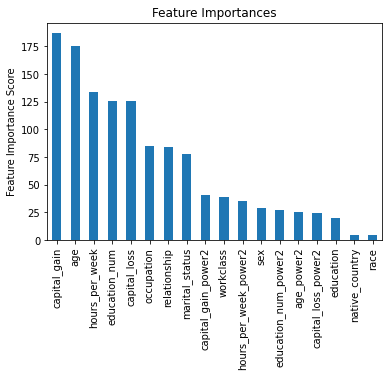

In [127]:
feature_importances = pd.Series(clf.get_booster().get_score(importance_type='weight')).sort_values(ascending=False)
feature_importances.head(20).plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score');
plt.savefig(os.path.join(reports, 'xgboost_importances.jpg'), bbox_inches='tight')

In [128]:
print('RESULTS FOR XGB MODEL')
pprint(ml_dict)

RESULTS FOR XGB MODEL
{'standard': {'tree_xgboost': {'best_params': {'base_score': 0.5,
                                               'booster': 'gbtree',
                                               'colsample_bylevel': 1,
                                               'colsample_bynode': 1,
                                               'colsample_bytree': 0.8,
                                               'gamma': 0,
                                               'learning_rate': 0.1,
                                               'max_delta_step': 0,
                                               'max_depth': 5,
                                               'min_child_weight': 1,
                                               'missing': None,
                                               'n_estimators': 50,
                                               'n_jobs': 1,
                                               'nthread': 8,
                                               'ob

# save model parameters

In [129]:
save_model_parameters(models_reports, model_type, clf)

# save model metrics

In [130]:
save_model_metrics(model_outputs, model_type, ml_dict)

# save final transformed data (for interpretability checkup)

In [131]:
data_transformed.to_csv(os.path.join(outputs, 'data_interpretability.csv'))